# Matrix multiplication from foundations
The foundations we'll assume throughout this course are:

- Python
- matplotlib
- The Python standard library
- Jupyter notebooks and nbdev

In [2]:
from pathlib import Path
import pickle, gzip, math, os, shutil, matplotlib as mpl, matplotlib.pyplot as plt

In [3]:
# get data
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'
path_gz

PosixPath('data/mnist.pkl.gz')

In [4]:
from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [5]:
!ls -l data

total 16656
-rw-r--r-- 1 agastya agastya 17051982 Jun 22 21:47 mnist.pkl.gz


In [6]:
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [7]:
x_train.shape

(50000, 784)

50k images in form of vector

In [9]:
lst1 = list(x_train[0])   # first image
vals = lst1[200:210]
vals

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125]

In [10]:
def chunks(x, size):
    for i in range(0, len(x), size):
        yield x[i: i+size]

In [11]:
c=chunks(vals, 2)

In [12]:
next(c), next(c), next(c)

([0.0, 0.0], [0.0, 0.19140625], [0.9296875, 0.98828125])

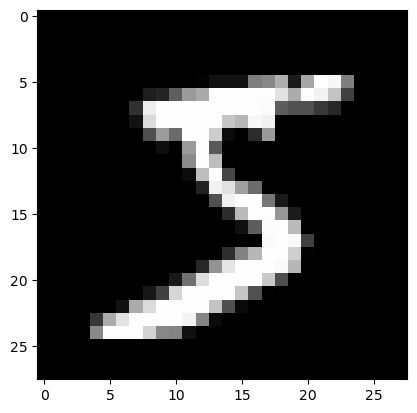

In [13]:
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(list(chunks(lst1, 28)))

### islice

In [14]:
from itertools import islice

In [15]:
it = iter(vals)
islice(it, 5)

In [16]:
list(islice(it, 5)), list(islice(it, 5)), list(islice(it, 5))

([0.0, 0.0, 0.0, 0.19140625, 0.9296875],
 [0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125],
 [])

In [17]:
it = iter(lst1)
img = list(iter(lambda: list(islice(it, 28)), []))   # [] is sentinel (stop until result is sentinel)

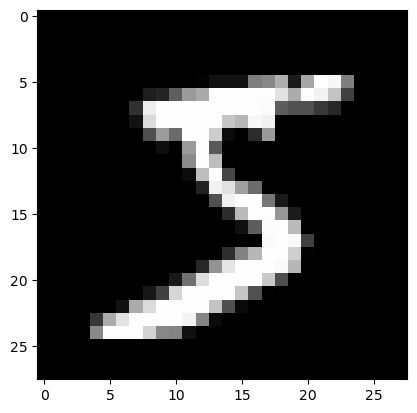

In [18]:
plt.imshow(img)

### Matrix and tensors

In [19]:
img[20][15]

0.98828125

In [20]:
class Matrix:
    def __init__(self, xs): self.xs = xs
    def __getitem__(self, idxs): 
        return self.xs[idxs[0]][idxs[1]]

In [22]:
m = Matrix(img)
m[20,15]

0.98828125

In [23]:
import torch
from torch import tensor

In [24]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
x_train.shape

torch.Size([50000, 784])

In [25]:
x_train.type()

'torch.FloatTensor'

In [26]:
img = x_train.reshape(-1, 28, 28)
img.shape

torch.Size([50000, 28, 28])

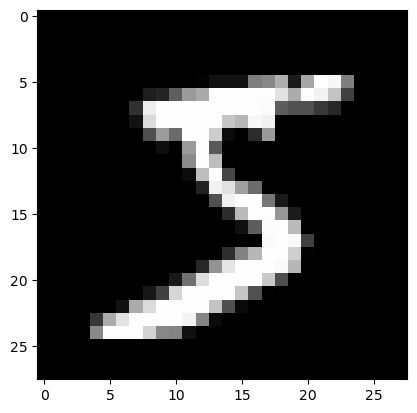

In [27]:
plt.imshow(img[0])

In [28]:
img[0, 20, 15]

tensor(0.9883)

In [29]:
n, c = x_train.shape
y_train, y_train.shape

(tensor([5, 0, 4,  ..., 8, 4, 8]), torch.Size([50000]))

In [30]:
min(y_train), max(y_train), y_train.min(), y_train.max()

(tensor(0), tensor(9), tensor(0), tensor(9))

### Random Numbers
based on Wichmann Hill algorithm used before Python 2.3

In [31]:
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x)+1, int(y)+1, int(z)+1

In [32]:
seed(53465651613213213123123)
rnd_state

(8236, 5245, 3108)

In [33]:
def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x,y,z
    return (x/30269 + y/30307 + z/30323) % 1.0

In [34]:
rand(),rand(),rand()

(0.7191168245841637, 0.3113002413339978, 0.9607327524666694)

In [35]:
if os.fork(): print(f'In parent: {rand()}')
else:
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)

In parent: 0.863725516521312
In child: 0.863725516521312


In [36]:
# tensor random
if os.fork(): print(f'In parent: {torch.rand(1)}')
else:
    print(f'In child: {torch.rand(1)}')
    os._exit(os.EX_OK)

In parent: tensor([0.5191])
In child: tensor([0.5191])


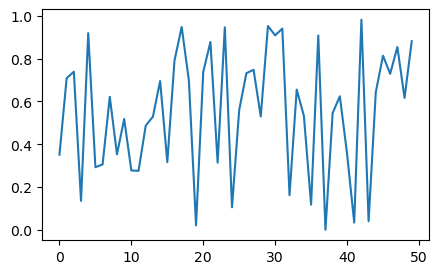

In [37]:
plt.figure(figsize=(5,3))
plt.plot([rand() for _ in range(0, 50)])

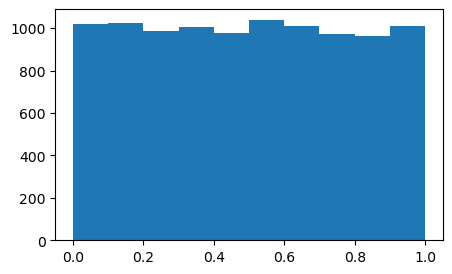

In [38]:
plt.figure(figsize=(5,3))
plt.hist([rand() for _ in range(10000)]);

In [39]:
%timeit -n 10 list(chunks([rand() for _ in range(7840)], 10))

6.08 ms ± 2.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
%timeit -n 10 torch.randn(784, 10)

The slowest run took 4.25 times longer than the fastest. This could mean that an intermediate result is being cached.
78.7 µs ± 47.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Matrix multiplication

In [41]:
torch.manual_seed(1)
weights = torch.randn(784, 10)
bias = torch.zeros(10)

In [42]:
m1 = x_valid[:5]
m2 = weights

In [43]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [44]:
ar,ac = m1.shape # n_rows * n_cols
br,bc = m2.shape
(ar,ac),(br,bc)

((5, 784), (784, 10))

In [45]:
t1 = torch.zeros(ar, bc)
t1.shape

torch.Size([5, 10])

In [46]:
for i in range(ar):
    for j in range(bc):
        for k in range(ac):
            t1[i, j] += m1[i, k] * m2[k,j]

In [47]:
t1.shape

torch.Size([5, 10])

In [48]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
t1

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [49]:
import numpy as np
np.set_printoptions(precision=2, linewidth=140)

In [50]:
# Functioning the above
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): c[i,j] += a[i,k] * b[k,j]
    return c
     

In [51]:
%timeit _=matmul(m1, m2)

839 ms ± 133 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
# Amount of operations
ar*bc*ac

39200

### Numba

In [53]:
!pip install numba

In [54]:
from numba import njit

In [55]:
@njit
def dot(a, b):
    res = 0.
    for i in range(len(a)): 
        res+=a[i]*b[i]
    return res

In [56]:
from numpy import array

In [57]:
%time dot(array([1.,2,3]),array([2.,3,4]))

CPU times: user 515 ms, sys: 115 ms, total: 630 ms
Wall time: 901 ms


20.0

In [58]:
%time dot(array([1.,2,3]),array([2.,3,4]))

CPU times: user 21 µs, sys: 4 µs, total: 25 µs
Wall time: 28.1 µs


20.0

Numba function takes normal duration for the first execution. After which the function gets compiled and there is 5000x improvement

In [59]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = dot(a[i,:], b[:,j])
    return c

In [60]:
m1a,m2a = m1.numpy(),m2.numpy()

In [61]:
from fastcore.test import *

In [62]:
test_close(t1, matmul(m1a, m2a))

In [63]:
%timeit -n 50 matmul(m1a,m2a)

442 µs ± 71.1 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## Element wise operations
TryAPL.org

In [64]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [65]:
a + b

tensor([12., 14.,  3.])

In [66]:
(a<b).float().mean()

tensor(0.67)

In [67]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Frobenius norm:
$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

In [68]:
sf = (m*m).sum()
sf

tensor(285.)

In [69]:
sf.sqrt()

tensor(16.88)

In [70]:
m[2:], m[:2]

(tensor([[7., 8., 9.]]),
 tensor([[1., 2., 3.],
         [4., 5., 6.]]))

In [71]:
m[2]

tensor([7., 8., 9.])

In [72]:
def matmul(a,b):
    (ar, ac), (br, bc) = a.shape, b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i, j] = (a[i:] * b[:j]).sum()
    return c

### Broadcasting
The term broadcasting describes how arrays with different shapes are treated during arithmetic operations.

From the Numpy Documentation:

The term broadcasting describes how numpy treats arrays with 
different shapes during arithmetic operations. Subject to certain 
constraints, the smaller array is “broadcast” across the larger 
array so that they have compatible shapes. Broadcasting provides a 
means of vectorizing array operations so that looping occurs in C
instead of Python. It does this without making needless copies of 
data and usually leads to efficient algorithm implementations.
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

#### Broadcasting with a scalar


In [73]:
a

tensor([10.,  6., -4.])

In [74]:
# One dimm with scalar
a>0

tensor([ True,  True, False])

In [75]:
m*2

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

#### Broadcasting a vector to a matrix
Although broadcasting a scalar is an idea that dates back to APL, the more powerful idea of broadcasting across higher rank tensors comes from a little known language called Yorick.

In [76]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [77]:
m.shape, c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [78]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [79]:
m/c

tensor([[0.10, 0.10, 0.10],
        [0.40, 0.25, 0.20],
        [0.70, 0.40, 0.30]])

In [80]:
# Visualizing the backend operation
t = c.expand_as(m)
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [81]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [82]:
# We don't really copy the rows, but it looks as if we did. In fact, the rows are given a stride of 0.
t.storage()

/tmp/ipykernel_203176/2382779785.py:2: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  t.storage()


 10.0
 20.0
 30.0
[torch.storage.TypedStorage(dtype=torch.float32, device=cpu) of size 3]

In [92]:
t.stride(), t.shape, t

((0, 1),
 torch.Size([3, 3]),
 tensor([[10., 20., 30.],
         [10., 20., 30.],
         [10., 20., 30.]]))

You can index with the special value [None] or use unsqueeze() to convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1)

In [93]:
c.unsqueeze(0), c[None, :]

(tensor([[10., 20., 30.]]), tensor([[10., 20., 30.]]))

In [94]:
c.shape, c.unsqueeze(0).shape

(torch.Size([3]), torch.Size([1, 3]))

In [95]:
# same can be done with None which creates another dimm
c.unsqueeze(1), c[:, None]

(tensor([[10.],
         [20.],
         [30.]]),
 tensor([[10.],
         [20.],
         [30.]]))

In [96]:
c.shape, c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([3, 1]))

In [97]:
c[None].shape,c[...,None].shape   # .... means all of the prev dimms

(torch.Size([1, 3]), torch.Size([3, 1]))

In [98]:
c[:,None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [99]:
m + c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [100]:
m + c[None,:]

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

### Broadcasting rules

In [101]:
c[None, :]

tensor([[10., 20., 30.]])

In [102]:
c[None, :].shape

torch.Size([1, 3])

In [103]:
c[:,None], c[:, None].shape

(tensor([[10.],
         [20.],
         [30.]]),
 torch.Size([3, 1]))

In [104]:
c[None,:] * c[:,None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [105]:
c[None] > c[:, None]

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

In [106]:
m*m

tensor([[ 1.,  4.,  9.],
        [16., 25., 36.],
        [49., 64., 81.]])

When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. It starts with the trailing dimensions, and works its way forward. Two dimensions are compatible when

- they are equal, or
- one of them is 1, in which case that dimension is broadcasted to make it the same size

Arrays do not need to have the same number of dimensions. For example, if you have a 256x256x3 array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3
The numpy documentation includes several examples of what dimensions can and can not be broadcast together.

### Matmul with broadcasting

In [107]:
digit = m1[0]
digit.shape,m2.shape

(torch.Size([784]), torch.Size([784, 10]))

In [108]:
digit[:,None].shape

torch.Size([784, 1])

In [109]:
digit[:,None].expand_as(m2).shape

torch.Size([784, 10])

In [111]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
#       c[i,j] = (a[i,:] * b[:,j]).sum()      # previous version
        c[i]   = (a[i,:,None] * b).sum(dim=0) # broadcast version
    return c

```
pseudocode
m1.shape=5,784 | m2.shape=784,10
for i in range(5):
    a[i,:, None] = [784,1]
    b.shape = [784,10]
    a(broadcasted) * b => [784, 784] * [784, 10] => [784, 10]
    (a*b).sum(dim=0) =Collapsing dim0=>[10]
c = [5,10]
```    

In [112]:
test_close(t1,matmul(m1, m2))

In [113]:
%timeit -n 50 _=matmul(m1, m2)

134 µs ± 20.7 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


Our time has gone from ~500ms to <0.1ms, an over 5000x improvement! We can run on the whole dataset now.

In [114]:
tr = matmul(x_train, weights)
tr

tensor([[  0.96,  -2.96,  -2.11,  ..., -15.09, -17.69,   0.60],
        [  6.89,  -0.34,   0.79,  ..., -17.13, -25.36,  16.23],
        [-10.18,   7.38,   4.13,  ...,  -6.73,  -6.79,  -1.58],
        ...,
        [  7.40,   7.64,  -3.50,  ...,  -1.02, -16.22,   2.07],
        [  3.25,   9.52,  -9.37,  ...,   2.98, -19.58,  -1.96],
        [ 15.70,   4.12,  -5.62,  ...,   8.08, -12.21,   0.42]])

In [115]:
tr.shape

torch.Size([50000, 10])

In [116]:
%time _=matmul(x_train, weights)


CPU times: user 1.99 s, sys: 7.17 ms, total: 2 s
Wall time: 1.39 s


Do broadcasting again

## Einstein Summation 

Einstein summation (einsum) is a compact representation for combining products and sums in a general way. The key rules are:

- Repeating letters between input arrays means that values along those axes will be multiplied together.
- Omitting a letter from the output means that values along that axis will be summed.

In [117]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [119]:
# c[i,j] += a[i,k] * b[k,j]
# c[i,j] += (a[i,k] * b[k,j]).sum()
mr = torch.einsum('ik,kj->ikj', m1, m2)
mr.shape

torch.Size([5, 784, 10])

In [121]:
mr.sum(1)

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [122]:
torch.einsum('ik,kj->ij', m1, m2)

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [123]:
def matmul(a,b): return torch.einsum('ik,kj->ij', a, b)

In [124]:
test_close(tr, matmul(x_train, weights), eps=1e-3)

In [125]:
%timeit -n 5 _=matmul(x_train, weights)

15.6 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## pytorch op
we can use pytorch's function or operator directly for matrix multiplication

In [126]:
test_close(tr, x_train@weights, eps=1e-3)

In [127]:
%timeit -n 5 _=torch.matmul(x_train, weights)

15.6 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## CUDA

In [129]:
def matmul(grid,a,b,c):
    i, j = grid
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i,k] * b[k, j]
        c[i, j] = tmp

In [132]:
res = torch.zeros(ar, bc)
res.shape

torch.Size([5, 10])

In [133]:
matmul((0,0), m1, m2, res)
res

tensor([[-10.94,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00]])

The above operation was performed for i, j = 0,0

In [143]:
# kernel is a function which to be passed
# matmul is the function
def launch_kernel(kernel, grid_x, grid_y, *args, **kwargs):
    for i in range(grid_x):
        for j in range(grid_y):
            kernel((i,j), *args, **kwargs)

In [144]:
res = torch.zeros(ar, bc)
launch_kernel(matmul, ar, bc, m1, m2, res)
res

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [145]:
from numba import cuda

In [146]:
# same as above
def matmul(grid, a,b,c):
    i,j = grid
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp

In [152]:
@cuda.jit
def matmul(a,b,c):
    i, j = cuda.grid(2)
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp

@cuda.jit decorator:
This decorator is used to mark a function as a CUDA kernel. It tells Numba to compile this function to run on the GPU. When you use this decorator, Numba will generate the appropriate CUDA C code and compile it for execution on the GPU

cuda.grid(2):
This is a Numba CUDA function that returns the absolute position of the current thread in a 2D grid of threads. It's a convenient way to get the unique coordinates for each thread in a 2D grid. The argument 2 specifies that we're working with a 2D grid.
In this case, i, j = cuda.grid(2) assigns the row and column indices to i and j respectively, which are then used to determine which element of the output matrix c this particular thread will compute

In [153]:
r = np.zeros(tr.shape)
m1g,m2g,rg = map(cuda.to_device, (x_train,weights,r))

In [154]:
r.shape

(50000, 10)

In [155]:
TPB = 16
rr,rc = r.shape
blockspergrid = (math.ceil(rr / TPB), math.ceil(rc / TPB))
blockspergrid

(3125, 1)

In [ ]:
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()
test_close(tr, r, eps=1e-3)

In [ ]:
m1c,m2c = x_train.cuda(),weights.cuda()

In [ ]:
r=(m1c@m2c).cpu()

In [ ]:
%timeit -n 10 r=(m1c@m2c).cpu()

Our broadcasting version was >500ms, and our CUDA version is around 0.5ms, which is another 1000x improvement compared to broadcasting. So our total speedup is around 5 million times